In [438]:
# Importing the libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

## 1) Cleaning data

In [ ]:
# Importing the dataset
path = '...'
file = 'data.csv'
file_path = path + file
pd.set_option('display.max_columns', None)
df = pd.read_csv(file_path)

In [440]:
# Displaying the number of observations of the dataset
print(df.shape[0])

# Displaying the first few rows of the dataset
print(df.head())

4181952
   obs_main  exch_main  common  primary_sec  permno        date  permco  \
0         1          1       1            1     NaN  2016-01-01     NaN   
1         1          1       1            1     NaN  2016-01-01     NaN   
2         1          1       1            1     NaN  2016-01-01     NaN   
3         1          1       1            1     NaN  2016-01-01     NaN   
4         1          1       1            1     NaN  2016-01-01     NaN   

       gvkey  iid         id excntry         eom size_grp    me    ret  \
0 294555.000  01W  329455501     IND  2016-01-31     nano 3.092  0.040   
1 313344.000  01W  331334401     IND  2016-01-31     nano 0.325  0.053   
2 314774.000  01W  331477401     PAK  2016-01-31     nano 1.282  0.088   
3 315389.000  01W  331538901     IND  2016-01-31     nano 0.284 -0.038   
4 316337.000  01W  331633701     IND  2016-01-31     nano 0.624  0.051   

   ret_local  prc_local curcd      sic   ff49  shares   prc  div12m_me  \
0      0.030     65.00

In [441]:
# Keep only the columns we need
df_tidy = df[['date', 'excntry', 'me', 'ret', 'ff49', 'age', 'qmj', 'qmj_prof', 'qmj_growth', 'qmj_safety', 
              'id', 'eom', 'ret_local', 'be_me', 'div12m_me', 'roe_be_std']]

# Drop QMJ with missing values
df_tidy = df_tidy.dropna(subset=['qmj'])

# Used countries
countries_to_keep = [
    "AUS", "AUT", "BEL", "CAN", "DNK", "FIN", "FRA", "DEU", "GRC", "HKG", "IRL", "ISR", "ITA", "JPN", 
    "NLD", "NZL", "NOR", "PRT", "SGP", "ESP", "SWE", "CHE", "GBR", "USA"
]

# Drop unused countries
df_tidy = df_tidy[df_tidy["excntry"].isin(countries_to_keep)]

# Create yearly age from variable age
df_tidy['age_year'] = (df_tidy['age'])/12

# Convert 'date' column to datetime
df_tidy['date'] = pd.to_datetime(df_tidy['date'])

# Change any date that is not at the end of the month to the end of the month
df_tidy['date'] = df_tidy['date'] + pd.offsets.MonthEnd(0)

# Set the 'date' column as the index
df_tidy.set_index('date', inplace=True)

# Drop all dates prior to December 2016
df_tidy = df_tidy[df_tidy.index >= '2016-12-01']

# Drop rows with NaN values in the 'ret' column
df_tidy.dropna(subset=['ret'], inplace=True)

# Ensure the 'id' column is of type string
df_tidy['id'] = df_tidy['id'].astype(str)

# Check if the largest values make sense or if they skew the data
print("Largest returns: ")
print(df_tidy.nlargest(10, 'ret')[['id', 'ret', 'qmj']])

Largest returns: 
                   id      ret    qmj
date                                 
2017-09-30  101343103 9499.000 -1.656
2023-09-30  332195101 7805.195 -1.294
2023-09-30  328504301 4048.464 -0.551
2023-09-30  328573401 2526.256 -1.616
2021-09-30  324910301 2115.227 -1.400
2018-11-30  328609101  682.655 -0.261
2018-07-31  116646001  429.000 -1.686
2020-04-30  323573601  331.052 -0.892
2017-06-30  327540401  200.208 -1.240
2023-07-31  331693601  158.012  0.763


In [442]:
# Eliminate return observations larger than 200, balance it by also eliminating the smallest ones
# Id values of the rows with the top ret_local values
top_10_ids = df_tidy.nlargest(9, 'ret')[['id', 'ret', 'qmj']]
bottom_10_ids = df_tidy.nsmallest(9, 'ret')[['id', 'ret', 'qmj']]

# Extract the id values of these rows
top_10_id_values = top_10_ids['id'].unique()
bottom_10_id_values = bottom_10_ids['id'].unique()

# Combine the top and bottom id values
id_values_to_drop = set(top_10_id_values).union(set(bottom_10_id_values))

# Drop the rows in df_tidy that have these id values
df_tidy = df_tidy[~df_tidy['id'].isin(id_values_to_drop)]

# Create a DataFrame for excntry == USA
df_usa = df_tidy[df_tidy['excntry'] == 'USA']

print(df_tidy)

           excntry      me    ret   ff49  age    qmj  qmj_prof  qmj_growth  \
date                                                                         
2016-12-31     AUS   0.613  0.002 27.000  240 -0.615    -0.490      -0.303   
2016-12-31     USA  75.211  0.047    NaN  204 -0.862    -0.366       0.733   
2016-12-31     AUS  33.142  0.090 34.000   72 -1.589    -1.540      -1.168   
2016-12-31     AUS 505.093 -0.057    NaN  396  0.447     1.348      -0.354   
2016-12-31     NZL 102.086 -0.002 41.000  396  1.270     1.529      -0.674   
...            ...     ...    ...    ...  ...    ...       ...         ...   
2024-01-31     NOR 766.469  0.026    NaN  109 -0.046     0.655      -0.445   
2024-01-31     HKG 372.120 -0.048    NaN   85  0.938     1.466       0.920   
2024-01-31     ESP 318.166 -0.059    NaN  481 -0.917    -1.228      -0.898   
2024-01-31     ITA 264.211 -0.018    NaN   85 -1.446    -1.402      -1.099   
2024-01-31     ESP 502.292 -0.051    NaN  481 -1.503    -1.499  

In [443]:
# Display unique id counts
print(df_tidy['id'].nunique())

# Display unique id counts by country
print(df_tidy.groupby('excntry')['id'].nunique())

# Display unique id counts by industry
print(df_tidy.groupby('ff49')['id'].nunique())

23891
excntry
AUS    2090
AUT      70
BEL     148
CAN     883
CHE     254
DEU     783
DNK     164
ESP     236
FIN     179
FRA     756
GBR    1780
GRC     190
HKG    2533
IRL      36
ISR     474
ITA     415
JPN    3412
NLD     121
NOR     298
NZL     143
PRT      57
SGP     733
SWE     921
USA    7215
Name: id, dtype: int64
ff49
1.000       94
2.000      415
3.000       44
4.000      106
5.000       12
6.000      142
7.000      323
8.000      144
9.000      311
10.000     261
11.000     224
12.000     497
13.000    1258
14.000     411
15.000     156
16.000     120
17.000     406
18.000     621
19.000     263
20.000      49
21.000     674
22.000     297
23.000     282
24.000      57
25.000      55
26.000      20
27.000     396
28.000     824
29.000      84
30.000     706
31.000     289
32.000     388
33.000     246
34.000    1234
35.000     209
36.000    1795
37.000     748
38.000     236
39.000     171
40.000      62
41.000     592
42.000     864
43.000     831
44.000     372
45.000    

## 2) Figure 1

In [444]:
# Formula to compute Newey-West adjusted T-Statistics
def compute_newey_west_tstat(hl_series, lag=60): # 5 years lag
    if len(hl_series) < 2:  # Ensure sufficient observations
        return np.nan

    hl_series = np.array(hl_series)  # Convert to NumPy array
    hl_series = hl_series[~np.isnan(hl_series)]  # Remove NaN values

    if len(hl_series) < 2:
        return np.nan  # Still not enough observations

    # Create a constant column for regression (needed for HAC estimation)
    X = np.ones(len(hl_series))  # Intercept-only model

    # Fit OLS regression and compute HAC standard errors
    model = sm.OLS(hl_series, X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return model.tvalues[0]  # Return the Newey-West adjusted t-stat

# Compute quality persistence summary
def compute_persistence_summary(df):

    def create_future_quality_portfolios_var(formation_date, quality_col='qmj', horizon_months=1): # Create 
        try:
            formation_data = df.loc[formation_date].copy()
        except KeyError:
            return None

        # Drop missing quality values
        formation_data = formation_data.dropna(subset=[quality_col])
        if formation_data.empty:
            return None

        # Assign stocks to 10 deciles
        formation_data['portfolio'] = pd.qcut(formation_data[quality_col], 10, labels=False) + 1

        # Compute the future date
        future_date = formation_date + pd.DateOffset(months=horizon_months)
        if future_date not in df.index:
            return None

        try:
            # Retrieve future quality data
            future_data = df.loc[future_date][['id', quality_col]].dropna()
        except KeyError:
            return None
        if future_data.empty:
            return None

        # Merge formation data with future data on 'id'
        merged = formation_data[['id', 'portfolio']].merge(
            future_data, on='id', how='inner', suffixes=('_form', '_fut')
        )
        if merged.empty:
            return None

        # Compute mean future quality per portfolio
        return merged.groupby('portfolio')[quality_col].mean()

    # Compute Persistence for Overall Quality 'qmj' at Future Horizons
    qmj_horizons = [12, 36, 60]
    summary_dict = {}

    for horizon in qmj_horizons:
        results = {p: [] for p in range(1, 11)}
        hl_series = []

        formation_dates = sorted(df.index.unique())

        for form_date in formation_dates:
            pfq = create_future_quality_portfolios_var(form_date, quality_col='qmj', horizon_months=horizon)
            if pfq is not None:
                for p in range(1, 11):
                    if p in pfq.index:
                        results[p].append(pfq.loc[p])
                if 1 in pfq.index and 10 in pfq.index:
                    hl_series.append(pfq.loc[10] - pfq.loc[1])

        avg_values = {f'P{p}': np.mean(results[p]) if results[p] else np.nan for p in range(1, 11)}
        avg_values['H-L'] = np.mean(hl_series) if hl_series else np.nan
        avg_values['T-stat'] = compute_newey_west_tstat(hl_series, lag=60) if hl_series else np.nan

        summary_dict[f'Quality t+{horizon}M'] = avg_values

    # Compute Formation Quality (Time t) for Overall Quality 'qmj'
    results_t0 = {p: [] for p in range(1, 11)}
    hl_series_t0 = []
    
    for form_date in sorted(df.index.unique()):
        pfq = create_future_quality_portfolios_var(form_date, quality_col='qmj', horizon_months=0)
        if pfq is not None:
            for p in range(1, 11):
                if p in pfq.index:
                    results_t0[p].append(pfq.loc[p])
            if 1 in pfq.index and 10 in pfq.index:
                hl_series_t0.append(pfq.loc[10] - pfq.loc[1])

    avg_values_t0 = {f'P{p}': np.mean(results_t0[p]) if results_t0[p] else np.nan for p in range(1, 11)}
    avg_values_t0['H-L'] = np.mean(hl_series_t0) if hl_series_t0 else np.nan
    avg_values_t0['T-stat'] = compute_newey_west_tstat(hl_series_t0, lag=60) if hl_series_t0 else np.nan
    summary_dict['Quality t'] = avg_values_t0

    # Compute Additional Quality Measures at t+60 for qmj_prof, qmj_growth, and qmj_safety
    additional_quality_vars = ['qmj_prof', 'qmj_growth', 'qmj_safety']

    for qvar in additional_quality_vars:
        results_var = {p: [] for p in range(1, 11)}
        hl_series_var = []

        for form_date in formation_dates:
            pfq = create_future_quality_portfolios_var(form_date, quality_col=qvar, horizon_months=60)
            if pfq is not None:
                for p in range(1, 11):
                    if p in pfq.index:
                        results_var[p].append(pfq.loc[p])
                if 1 in pfq.index and 10 in pfq.index:
                    hl_series_var.append(pfq.loc[10] - pfq.loc[1])

        avg_values_var = {f'P{p}': np.mean(results_var[p]) if results_var[p] else np.nan for p in range(1, 11)}
        avg_values_var['H-L'] = np.mean(hl_series_var) if hl_series_var else np.nan
        avg_values_var['T-stat'] = compute_newey_west_tstat(hl_series_var, lag=60) if hl_series_var else np.nan

        summary_dict[f'Quality t+60 ({qvar})'] = avg_values_var

    return pd.DataFrame(summary_dict).T  # Convert to DataFrame


panel_B = compute_persistence_summary(df_tidy)
panel_A = compute_persistence_summary(df_usa)

# Combine both panels into a single DataFrame with a MultiIndex
panel_A['Panel'] = 'Panel A (U.S. Stocks)'
panel_B['Panel'] = 'Panel B (Global Stocks)'
combined = pd.concat([panel_A, panel_B])

# Reset index and set MultiIndex with 'Panel' and 'Quality_Horizon'
combined = combined.reset_index().rename(columns={'index': 'Quality_Horizon'})
combined.set_index(['Panel', 'Quality_Horizon'], inplace=True)

# Print the combined results
print("\nCombined Panels with Newey-West Adjusted T-Statistics:")
print(combined)


Combined Panels with Newey-West Adjusted T-Statistics:
                                                      P1     P2     P3     P4  \
Panel                   Quality_Horizon                                         
Panel A (U.S. Stocks)   Quality t+12M             -1.124 -0.784 -0.558 -0.319   
                        Quality t+36M             -0.692 -0.460 -0.340 -0.150   
                        Quality t+60M             -0.302 -0.125 -0.151 -0.029   
                        Quality t                 -1.558 -1.211 -0.865 -0.519   
                        Quality t+60 (qmj_prof)   -0.853 -0.266 -0.041  0.106   
                        Quality t+60 (qmj_growth)  0.508  0.176  0.007 -0.000   
                        Quality t+60 (qmj_safety) -0.899 -0.651 -0.406 -0.242   
Panel B (Global Stocks) Quality t+12M             -1.094 -0.767 -0.546 -0.321   
                        Quality t+36M             -0.678 -0.462 -0.337 -0.192   
                        Quality t+60M             -0.

In [445]:
# Export to Excel
#combined.to_excel("monthly_portfolios.xlsx")  # Keep index if 'date' is the index
#combined.to_excel("monthly_portfolios_usa.xlsx")


## 3) Figure 3

In [446]:
# Load the Excel file
file2 = 'ff.xlsx'
file_path2 = path + file2
factor_data = pd.read_excel(file_path2)

# Ensure column names are correct (adjust if necessary)
factor_data.columns = ['date', 'Mkt-RF', 'SMB', 'HML', 'MOM', 'RF']

# Convert 'date' column to datetime format
factor_data['date'] = pd.to_datetime(factor_data['date'])

# Convert percentages to decimals (if needed)
factor_data[['Mkt-RF', 'SMB', 'HML', 'MOM', 'RF']] = factor_data[['Mkt-RF', 'SMB', 'HML', 'MOM', 'RF']] / 100

# Merge factor data into `df_tidy` using 'date' as the key
df_tidy = pd.merge(df_tidy, factor_data, on='date', how='left') 
df_usa = pd.merge(df_usa, factor_data, on='date', how='left') 

# Calculate excess returns
df_tidy['excess_return'] = df_tidy['ret'] - df_tidy['RF'] 
df_usa['excess_return'] = df_usa['ret'] - df_usa['RF']

# Ensure 'date' is in datetime format
df_tidy['date'] = pd.to_datetime(df_tidy['date'])
df_usa['date'] = pd.to_datetime(df_usa['date'])

# Set 'date' as the index
df_tidy.set_index('date', inplace=True)
df_usa.set_index('date', inplace=True)

# Set 'date' as index
factor_data.set_index('date', inplace=True)

# Ensure factor_data ends at 2024-01-31
factor_data = factor_data[factor_data.index <= "2024-01-31"]

# Compute 'MKT' as 'Mkt-RF' + 'RF'
factor_data['MKT'] = factor_data['Mkt-RF'] + factor_data['RF']

print(factor_data.head())

            Mkt-RF    SMB    HML   MOM     RF    MKT
date                                                
2016-12-31   0.018  0.001  0.035 0.000 -0.003  0.016
2017-01-31   0.019 -0.012 -0.028 0.000 -0.009  0.010
2017-02-28   0.036 -0.020 -0.017 0.000 -0.017  0.019
2017-03-31   0.002  0.011 -0.034 0.000 -0.010 -0.009
2017-04-30   0.011  0.007 -0.021 0.001  0.005  0.016


In [447]:
# Function to compute monthly value-weighted excess returns for QMJ-based portfolios
def compute_vw_excess_returns(df, num_groups=10):
    # Ensure no missing values in necessary columns
    df = df.dropna(subset=['qmj', 'excess_return', 'me'])

    # Assign stocks to deciles based on QMJ within each month
    df['qmj_group'] = df.groupby('date')['qmj'].transform(lambda x: pd.qcut(x, num_groups, labels=False) + 1)

    # Compute value-weighted excess return for each decile portfolio
    vw_excess_returns = df.groupby(['date', 'qmj_group']).apply(
        lambda x: np.average(x['excess_return'], weights=x['me'])
    ).reset_index(name='vw_excess_return')

    # Pivot to wide format for presentation
    vw_excess_returns_wide = vw_excess_returns.pivot(index='date', columns='qmj_group', values='vw_excess_return')

    # Rename columns for readability
    vw_excess_returns_wide.columns = [f'P{i}' for i in range(1, num_groups+1)]

    # Compute the High-Minus-Low (H-L) portfolio return (P10 - P1)
    vw_excess_returns_wide['H-L'] = vw_excess_returns_wide['P10'] - vw_excess_returns_wide['P1']

    return vw_excess_returns_wide

# Compute portfolio excess returns for global and US stocks
monthly_portfolios = compute_vw_excess_returns(df_tidy)
monthly_portfolios_usa = compute_vw_excess_returns(df_usa)

print(monthly_portfolios)

/var/folders/sh/cr02tnp57hd33gv6pvdjgbj00000gn/T/ipykernel_20234/3379858669.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_excess_returns = df.groupby(['date', 'qmj_group']).apply(


               P1     P2     P3     P4     P5     P6     P7     P8     P9  \
date                                                                        
2016-12-31  0.025  0.035  0.045  0.031  0.038  0.032  0.025  0.021  0.015   
2017-01-31  0.070  0.032  0.044  0.028  0.039  0.042  0.038  0.043  0.050   
2017-02-28  0.025  0.026  0.023  0.036  0.043  0.044  0.056  0.057  0.045   
2017-03-31  0.015  0.028  0.018  0.025  0.023  0.027  0.025  0.029  0.028   
2017-04-30 -0.004  0.009  0.008  0.008  0.012  0.010  0.008  0.014  0.024   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2023-09-30 -0.041 -0.043 -0.041 -0.048 -0.041 -0.054 -0.039 -0.039 -0.037   
2023-10-31 -0.063 -0.073 -0.067 -0.056 -0.061 -0.046 -0.034 -0.046 -0.049   
2023-11-30  0.094  0.105  0.096  0.094  0.074  0.066  0.064  0.066  0.068   
2023-12-31  0.188  0.156  0.125  0.139  0.134  0.127  0.106  0.102  0.115   
2024-01-31 -0.093 -0.073 -0.044 -0.053 -0.058 -0.053  0.002 -0.049 -0.043   

/var/folders/sh/cr02tnp57hd33gv6pvdjgbj00000gn/T/ipykernel_20234/3379858669.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  vw_excess_returns = df.groupby(['date', 'qmj_group']).apply(


In [448]:
monthly_portfolios = monthly_portfolios.reset_index()
monthly_portfolios_usa = monthly_portfolios_usa.reset_index()

def run_factor_model(portfolio_returns, factor_data, model='CAPM'):
    results = {}

    # Select relevant factors
    if model == 'CAPM':
        factors = ['MKT']
    elif model == 'FF3':
        factors = ['MKT', 'SMB', 'HML']
    elif model == 'Carhart':
        factors = ['MKT', 'SMB', 'HML', 'MOM']
    else:
        raise ValueError("Invalid model. Choose 'CAPM', 'FF3', or 'Carhart'.")

    # Ensure 'date' is set as index in portfolio_returns
    portfolio_returns = portfolio_returns.set_index('date')

    for portfolio in range(1, 11):  # Loop through decile portfolios P1-P10
        y = portfolio_returns[f'P{portfolio}'].dropna()

        # Ensure factor data aligns correctly
        X = factor_data.loc[y.index, factors].dropna()
        X = sm.add_constant(X)

        # Run OLS regression with Newey-West standard errors
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 60})

        # Compute tracking error (std dev of residuals)
        tracking_error = np.std(model.resid)

        # Compute information ratio (alpha / tracking error)
        information_ratio = (model.params['const'] / tracking_error) * np.sqrt(12) if tracking_error != 0 else np.nan

        # Store alpha, beta, t-statistics, and adjusted R-squared
        results[f'P{portfolio}'] = {
            'Alpha': model.params['const'],
            'T-stat': model.tvalues['const'],
            'MKT': model.params.get('MKT', np.nan),
            'Adjusted R-squared': model.rsquared_adj,
            'Tracking Error': tracking_error,
            'Information_Ratio': information_ratio
        }

    # Run regression for High-Minus-Low (H-L) portfolio
    y = portfolio_returns['H-L'].dropna()
    X = factor_data.loc[y.index, factors].dropna()
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 60})

    tracking_error = np.std(model.resid)
    information_ratio = (model.params['const'] / tracking_error) * np.sqrt(12) if tracking_error != 0 else np.nan

    results['H-L'] = {
        'Alpha': model.params['const'],
        'T-stat': model.tvalues['const'],
        'MKT': model.params.get('MKT', np.nan),
        'Adjusted R-squared': model.rsquared_adj,
        'Tracking Error': tracking_error,
        'Information_Ratio': information_ratio
    }

    return pd.DataFrame(results).T

# Run the regressions
capm_results = run_factor_model(monthly_portfolios, factor_data, model='CAPM')
ff3_results = run_factor_model(monthly_portfolios, factor_data, model='FF3')
carhart_results = run_factor_model(monthly_portfolios, factor_data, model='Carhart')

# Run the regressions for the U.S.
capm_results_usa = run_factor_model(monthly_portfolios_usa, factor_data, model='CAPM')
ff3_results_usa = run_factor_model(monthly_portfolios_usa, factor_data, model='FF3')
carhart_results_usa = run_factor_model(monthly_portfolios_usa, factor_data, model='Carhart')

In [449]:
# Drop non-numeric columns before calculations
monthly_portfolios_numeric = monthly_portfolios.select_dtypes(include=[np.number])

# Compute Sharpe Ratio for each decile and H-L portfolio
sharpe_ratios = (monthly_portfolios_numeric.mean(axis=0) / monthly_portfolios_numeric.std(axis=0)) * np.sqrt(12)

# Compute Adjusted R2 for Carhart model
adjusted_r2_values = carhart_results['Adjusted R-squared']

# Compute T-statistic for Excess Returns
num_months = monthly_portfolios_numeric.shape[0]
excess_return_means = monthly_portfolios_numeric.mean(axis=0)
excess_return_std = monthly_portfolios_numeric.std(axis=0)
excess_return_tstats = excess_return_means / (excess_return_std / np.sqrt(num_months))

# Compute Sharpe Ratio for each decile and H-L portfolio
monthly_portfolios_numeric_usa = monthly_portfolios_usa.select_dtypes(include=[np.number])
sharpe_ratios_usa = (monthly_portfolios_numeric_usa.mean(axis=0) / monthly_portfolios_numeric_usa.std(axis=0)) * np.sqrt(12)

# Compute Adjusted R2 for Carhart model
adjusted_r2_values_usa = carhart_results_usa['Adjusted R-squared']

# Compute T-statistic for Excess Returns
num_months = monthly_portfolios_numeric_usa.shape[0]
excess_return_means_usa = monthly_portfolios_numeric_usa.mean(axis=0)
excess_return_std_usa = monthly_portfolios_numeric_usa.std(axis=0)
excess_return_tstats_usa = excess_return_means_usa / (excess_return_std_usa / np.sqrt(num_months))

# Organize into a dataframe
table_3_replication = pd.DataFrame({
    "Portfolio": ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10", "H-L"],
    "Excess return": monthly_portfolios_numeric.mean().tolist(),
    "Excess return T-stat": excess_return_tstats.tolist(),
    "CAPM alpha": capm_results["Alpha"].tolist(),
    "CAPM t-stat": capm_results["T-stat"].tolist(),
    "3-factor alpha": ff3_results["Alpha"].tolist(),
    "3-factor t-stat": ff3_results["T-stat"].tolist(),
    "4-factor alpha": carhart_results["Alpha"].tolist(),
    "4-factor t-stat": carhart_results["T-stat"].tolist(),
    "Beta": capm_results["MKT"].tolist(),
    "Sharpe Ratio": sharpe_ratios.tolist(),
    "Information Ratio": carhart_results["Information_Ratio"].tolist(),
    "Adjusted R²": adjusted_r2_values.tolist()
})

# Display results
print(table_3_replication.T)

# Organize into a dataframe
table_3_replication_usa = pd.DataFrame({
    "Portfolio": ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10", "H-L"],
    "Excess return": monthly_portfolios_numeric_usa.mean().tolist(),
    "Excess return T-stat": excess_return_tstats_usa.tolist(),
    "CAPM alpha": capm_results_usa["Alpha"].tolist(),
    "CAPM t-stat": capm_results_usa["T-stat"].tolist(),
    "3-factor alpha": ff3_results_usa["Alpha"].tolist(),
    "3-factor t-stat": ff3_results_usa["T-stat"].tolist(),
    "4-factor alpha": carhart_results_usa["Alpha"].tolist(),
    "4-factor t-stat": carhart_results_usa["T-stat"].tolist(),
    "Beta": capm_results_usa["MKT"].tolist(),
    "Sharpe Ratio": sharpe_ratios_usa.tolist(),
    "Information Ratio": carhart_results_usa["Information_Ratio"].tolist(),
    "Adjusted R²": adjusted_r2_values_usa.tolist()
})

# Display results
print(table_3_replication_usa.T)


                        0     1     2     3     4     5     6     7     8   \
Portfolio               P1    P2    P3    P4    P5    P6    P7    P8    P9   
Excess return        0.022 0.015 0.014 0.013 0.012 0.013 0.014 0.012 0.014   
Excess return T-stat 2.017 1.480 1.467 1.497 1.368 1.537 1.657 1.546 1.817   
CAPM alpha           0.019 0.012 0.011 0.011 0.010 0.011 0.011 0.010 0.010   
CAPM t-stat          3.258 2.736 2.167 2.810 2.928 2.769 3.034 3.179 3.599   
3-factor alpha       0.023 0.015 0.014 0.014 0.013 0.013 0.013 0.011 0.012   
3-factor t-stat      5.090 4.258 3.899 4.487 4.017 3.964 4.505 3.566 4.445   
4-factor alpha       0.015 0.006 0.008 0.007 0.007 0.006 0.007 0.005 0.007   
4-factor t-stat      2.442 1.024 1.482 1.297 1.152 1.286 1.366 0.845 1.551   
Beta                 0.232 0.202 0.266 0.172 0.155 0.169 0.204 0.201 0.295   
Sharpe Ratio         0.753 0.553 0.548 0.559 0.511 0.574 0.619 0.578 0.679   
Information Ratio    0.609 0.297 0.386 0.329 0.328 0.312 0.342 0

In [450]:
# Export to Excel
#table_3_replication.T.to_excel("table3.xlsx")  # Keep index if 'date' is the index
#table_3_replication_usa.T.to_excel("table3_usa.xlsx")

## 4) Figure 4

In [451]:
def construct_quality_factors(df, quality_col):
    df = df.copy()
    
    # Define Size Groups
    def assign_size_group(sub_df):
        if sub_df['excntry'].iloc[0] == 'USA':
            size_threshold = sub_df[sub_df['excntry'] == 'USA']['me'].median()
        else:
            size_threshold = sub_df['me'].quantile(0.80)
        
        sub_df['size_group'] = np.where(sub_df['me'] >= size_threshold, 'Big', 'Small')
        return sub_df

    df = df.groupby(['date', 'excntry'], group_keys=False).apply(assign_size_group)

    # Define Quality Portfolios
    def assign_quality_portfolio(sub_df):
        sub_df = sub_df.dropna(subset=[quality_col])  # Ensure no NaNs in ranking
        
        # Define 30% thresholds
        high_threshold = sub_df[quality_col].quantile(0.70)
        low_threshold = sub_df[quality_col].quantile(0.30)
        
        # Assign Quality Portfolios
        sub_df['quality_portfolio'] = np.where(sub_df[quality_col] >= high_threshold, 'High-Quality',
                                        np.where(sub_df[quality_col] <= low_threshold, 'Junk', np.nan))
        
        return sub_df.dropna(subset=['quality_portfolio'])  # Keep only stocks in the 30%-30% split

    df_qmj = df.groupby(['date', 'size_group'], group_keys=False).apply(assign_quality_portfolio)

    # Compute Value-Weighted Excess Returns for Each Portfolio
    def value_weighted_return(sub_df):
        total_me = sub_df['me'].sum()
        return np.sum(sub_df['excess_return'] * (sub_df['me'] / total_me)) if total_me > 0 else np.nan

    factor_returns = df_qmj.groupby(["date", "size_group", "quality_portfolio"]).apply(value_weighted_return).unstack()

    # Merge Big & Small for Alignment
    factor_returns = factor_returns.reset_index()

    big_factor = factor_returns[factor_returns["size_group"] == "Big"].rename(columns={"High-Quality": "Big_HQ", "Junk": "Big_Junk"})
    small_factor = factor_returns[factor_returns["size_group"] == "Small"].rename(columns={"High-Quality": "Small_HQ", "Junk": "Small_Junk"})

    merged = pd.merge(big_factor[["date", "Big_HQ", "Big_Junk"]],
                      small_factor[["date", "Small_HQ", "Small_Junk"]],
                      on="date", how="inner")

    # Compute Factor
    merged[quality_col] = 0.5 * (merged["Big_HQ"] + merged["Small_HQ"]) - \
                           0.5 * (merged["Big_Junk"] + merged["Small_Junk"])

    return merged[['date', quality_col]]

# Compute Quality Factors
qmj_excess_returns = construct_quality_factors(df_tidy, 'qmj')
pmj_excess_returns = construct_quality_factors(df_tidy, 'qmj_prof')
smj_excess_returns = construct_quality_factors(df_tidy, 'qmj_safety')
gmj_excess_returns = construct_quality_factors(df_tidy, 'qmj_growth')

# Merge all factors into one DataFrame
quality_factors = qmj_excess_returns.merge(pmj_excess_returns, on='date')\
                                    .merge(smj_excess_returns, on='date')\
                                    .merge(gmj_excess_returns, on='date')

# Compute Quality Factors
qmj_excess_returns_usa = construct_quality_factors(df_usa, 'qmj')
pmj_excess_returns_usa = construct_quality_factors(df_usa, 'qmj_prof')
smj_excess_returns_usa = construct_quality_factors(df_usa, 'qmj_safety')
gmj_excess_returns_usa = construct_quality_factors(df_usa, 'qmj_growth')

# Merge all factors into one DataFrame
quality_factors_usa = qmj_excess_returns_usa.merge(pmj_excess_returns_usa, on='date')\
                                    .merge(smj_excess_returns_usa, on='date')\
                                    .merge(gmj_excess_returns_usa, on='date')

# Print the returns
print(quality_factors)
print(quality_factors_usa)

/var/folders/sh/cr02tnp57hd33gv6pvdjgbj00000gn/T/ipykernel_20234/1769415153.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['date', 'excntry'], group_keys=False).apply(assign_size_group)
/var/folders/sh/cr02tnp57hd33gv6pvdjgbj00000gn/T/ipykernel_20234/1769415153.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_qmj = df.groupby(['date', 'size_group'], group_keys=False).apply(assi

quality_portfolio       date    qmj  qmj_prof  qmj_safety  qmj_growth
0                 2016-12-31 -0.010    -0.008      -0.003      -0.005
1                 2017-01-31 -0.005     0.000      -0.008      -0.005
2                 2017-02-28  0.006     0.010      -0.001       0.003
3                 2017-03-31  0.012     0.016       0.006       0.008
4                 2017-04-30  0.021     0.023       0.011       0.016
..                       ...    ...       ...         ...         ...
81                2023-09-30  0.011    -0.012       0.009       0.015
82                2023-10-31  0.027     0.007       0.041       0.010
83                2023-11-30 -0.026    -0.002      -0.034      -0.015
84                2023-12-31 -0.036    -0.018      -0.042      -0.015
85                2024-01-31  0.020     0.019       0.016       0.002

[86 rows x 5 columns]
quality_portfolio       date    qmj  qmj_prof  qmj_safety  qmj_growth
0                 2016-12-31  0.006    -0.004       0.025       0.0

/var/folders/sh/cr02tnp57hd33gv6pvdjgbj00000gn/T/ipykernel_20234/1769415153.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  factor_returns = df_qmj.groupby(["date", "size_group", "quality_portfolio"]).apply(value_weighted_return).unstack()


In [452]:
# Ensure 'date' is in datetime format and set as index
quality_factors_usa['date'] = pd.to_datetime(quality_factors_usa['date'])
quality_factors_usa.set_index('date', inplace=True)

# Ensure 'date' is in datetime format and set as index
quality_factors['date'] = pd.to_datetime(quality_factors['date'])
quality_factors.set_index('date', inplace=True)

In [453]:
# Define function to run factor model for quality factors with full 4-factor details
def run_factor_model(factor_returns, factor_data, model='Carhart'):

    results = {}
    
    # Select relevant factors
    if model == 'CAPM':
        factors = ['MKT']
    elif model == 'FF3':
        factors = ['MKT', 'SMB', 'HML']
    elif model == 'Carhart':
        factors = ['MKT', 'SMB', 'HML', 'MOM']
    else:
        raise ValueError("Invalid model. Choose 'CAPM', 'FF3', or 'Carhart'.")

    for factor in factor_returns.columns:  # Loop through quality factors
        y = factor_returns[factor].dropna()

        # Ensure factor data aligns correctly
        X = factor_data.loc[y.index, factors].dropna()
        if X.empty or len(X) < 10:  # Prevent errors if insufficient data
            results[factor] = {f"{factor} Beta": None for factor in factors}
            results[factor].update({f"{factor} T-stat": None for factor in factors})
            results[factor].update({'Alpha': None, 'T-stat': None, 'Adjusted R-squared': None, 'Information Ratio': None})
            continue
        X = sm.add_constant(X)  # Add intercept

        # Run OLS regression with Newey-West standard errors
        model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 60})

        # Compute tracking error
        tracking_error = np.std(model.resid)

        # Compute information ratio (alpha / tracking error)
        information_ratio = (model.params['const'] / tracking_error) * np.sqrt(12) if tracking_error != 0 else np.nan

        # Store alpha, t-stat, adjusted R2, information ratio, and betas with t-stats
        results[factor] = {
            'Alpha': model.params['const'],
            'T-stat': model.tvalues['const'],
            'Adjusted R-squared': model.rsquared_adj,
            'Information Ratio': information_ratio
        }
        for factor_name in factors:
            results[factor][f"{factor_name} Beta"] = model.params.get(factor_name, None)
            results[factor][f"{factor_name} T-stat"] = model.tvalues.get(factor_name, None)

    return pd.DataFrame(results).T

# Run the regressions for each quality factor with CAPM, FF3, and Carhart models
capm_results = run_factor_model(quality_factors, factor_data, model='CAPM')
ff3_results = run_factor_model(quality_factors, factor_data, model='FF3')
carhart_results = run_factor_model(quality_factors, factor_data, model='Carhart')

# Drop non-numeric columns before calculations
quality_factors_numeric = quality_factors.select_dtypes(include=[np.number])

# Compute Sharpe Ratio for each factor
sharpe_ratios = (quality_factors_numeric.mean(axis=0) / quality_factors_numeric.std(axis=0)) * np.sqrt(12)

# Compute Adjusted R2 for Carhart model
adjusted_r2_values = carhart_results['Adjusted R-squared']

# Compute T-statistic for Excess Returns
num_months = quality_factors_numeric.shape[0]
excess_return_means = quality_factors_numeric.mean(axis=0)
excess_return_std = quality_factors_numeric.std(axis=0)
excess_return_tstats = excess_return_means / (excess_return_std / np.sqrt(num_months))

# Organize results into a DataFrame
table_4_replication = pd.DataFrame({
    "Factor": quality_factors_numeric.columns,
    "Excess Return": excess_return_means.values,
    "Excess Return T-stat": excess_return_tstats.values,
    "CAPM Alpha": capm_results["Alpha"].values,
    "CAPM T-stat": capm_results["T-stat"].values,
    "3-Factor Alpha": ff3_results["Alpha"].values,
    "3-Factor T-stat": ff3_results["T-stat"].values,
    "4-Factor Alpha": carhart_results["Alpha"].values,
    "4-Factor T-stat": carhart_results["T-stat"].values,
    "Sharpe Ratio": sharpe_ratios.values,
    "Information Ratio": carhart_results["Information Ratio"].values,
    "MKT Beta": carhart_results["MKT Beta"].values,
    "MKT T-stat": carhart_results["MKT T-stat"].values,
    "SMB Beta": carhart_results["SMB Beta"].values,
    "SMB T-stat": carhart_results["SMB T-stat"].values,
    "HML Beta": carhart_results["HML Beta"].values,
    "HML T-stat": carhart_results["HML T-stat"].values,
    "MOM Beta": carhart_results["MOM Beta"].values,
    "MOM T-stat": carhart_results["MOM T-stat"].values,
    "Adjusted R²": adjusted_r2_values.values
})

# Run the regressions for each quality factor with CAPM, FF3, and Carhart models
capm_results_usa = run_factor_model(quality_factors_usa, factor_data, model='CAPM')
ff3_results_usa = run_factor_model(quality_factors_usa, factor_data, model='FF3')
carhart_results_usa = run_factor_model(quality_factors_usa, factor_data, model='Carhart')

# Drop non-numeric columns before calculations
quality_factors_numeric_usa = quality_factors_usa.select_dtypes(include=[np.number])

# Compute Sharpe Ratio for each factor
sharpe_ratios_usa = (quality_factors_numeric_usa.mean(axis=0) / quality_factors_numeric_usa.std(axis=0)) * np.sqrt(12)

# Compute Adjusted R2 for Carhart model
adjusted_r2_values_usa = carhart_results_usa['Adjusted R-squared']

# Compute T-statistic for Excess Returns
num_months_usa = quality_factors_numeric_usa.shape[0]
excess_return_means_usa = quality_factors_numeric_usa.mean(axis=0)
excess_return_std_usa = quality_factors_numeric_usa.std(axis=0)
excess_return_tstats_usa = excess_return_means_usa / (excess_return_std_usa / np.sqrt(num_months_usa))

# Organize results into a DataFrame
table_4_replication_usa = pd.DataFrame({
    "Factor": quality_factors_numeric_usa.columns,
    "Excess Return": excess_return_means_usa.values,
    "Excess Return T-stat": excess_return_tstats_usa.values,
    "CAPM Alpha": capm_results_usa["Alpha"].values,
    "CAPM T-stat": capm_results_usa["T-stat"].values,
    "3-Factor Alpha": ff3_results_usa["Alpha"].values,
    "3-Factor T-stat": ff3_results_usa["T-stat"].values,
    "4-Factor Alpha": carhart_results_usa["Alpha"].values,
    "4-Factor T-stat": carhart_results_usa["T-stat"].values,
    "Sharpe Ratio": sharpe_ratios_usa.values,
    "Information Ratio": carhart_results_usa["Information Ratio"].values,
    "MKT Beta": carhart_results_usa["MKT Beta"].values,
    "MKT T-stat": carhart_results_usa["MKT T-stat"].values,
    "SMB Beta": carhart_results_usa["SMB Beta"].values,
    "SMB T-stat": carhart_results_usa["SMB T-stat"].values,
    "HML Beta": carhart_results_usa["HML Beta"].values,
    "HML T-stat": carhart_results_usa["HML T-stat"].values,
    "MOM Beta": carhart_results_usa["MOM Beta"].values,
    "MOM T-stat": carhart_results_usa["MOM T-stat"].values,
    "Adjusted R²": adjusted_r2_values_usa.values
})

# Combine the two tables
combined_table = pd.concat([table_4_replication, table_4_replication_usa], keys=['Global', 'USA'])

# Transpose the table for better readability
transposed_table = combined_table.T

print(transposed_table)


                     Global                                      USA  \
                          0         1           2           3      0   
Factor                  qmj  qmj_prof  qmj_safety  qmj_growth    qmj   
Excess Return        -0.003    -0.001      -0.007       0.001 -0.010   
Excess Return T-stat -1.120    -0.616      -2.118       0.424 -2.175   
CAPM Alpha           -0.004    -0.003      -0.006      -0.000 -0.009   
CAPM T-stat          -1.746    -1.531      -2.397      -0.524 -3.064   
3-Factor Alpha       -0.005    -0.004      -0.007      -0.001 -0.011   
3-Factor T-stat      -3.762    -2.950      -4.595      -1.351 -4.870   
4-Factor Alpha       -0.005    -0.004      -0.007      -0.000 -0.009   
4-Factor T-stat      -3.010    -2.487      -4.234      -0.250 -2.975   
Sharpe Ratio         -0.418    -0.230      -0.791       0.158 -0.812   
Information Ratio    -0.934    -0.827      -1.177      -0.070 -0.981   
MKT Beta             -0.011     0.087      -0.144       0.075 -0

In [454]:
# Export to Excel
#transposed_table.to_excel("table4.xlsx")

## 5) Plotting Returns

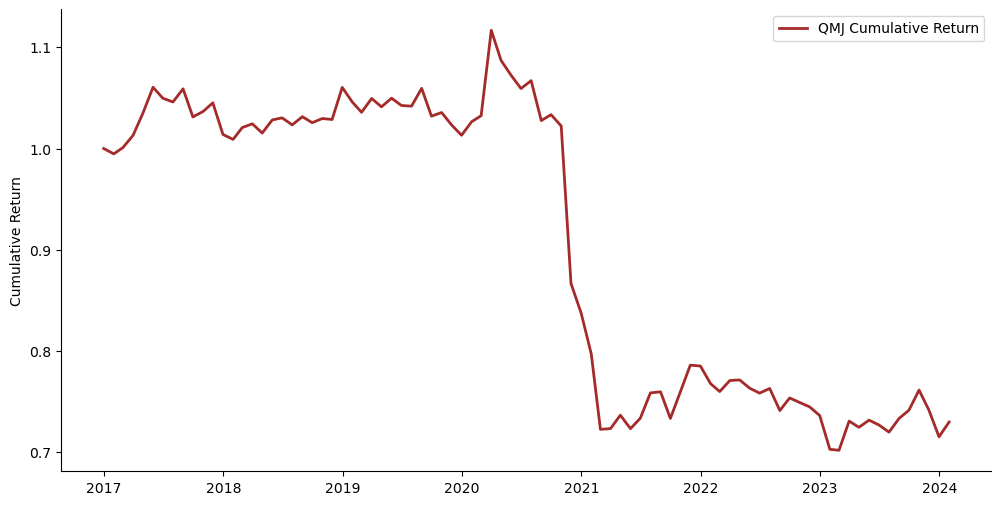

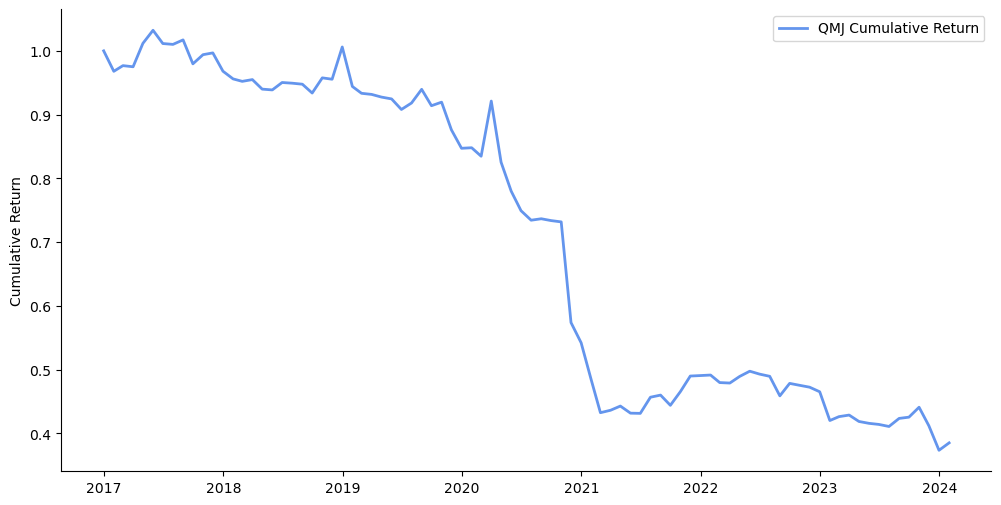

In [455]:
# Compute cumulative returns for Global
quality_factors["cumulative_qmj"] = (quality_factors["qmj"] + 1).cumprod()
quality_factors["cumulative_qmj"] = quality_factors["cumulative_qmj"] / quality_factors["cumulative_qmj"].iloc[0]  # Normalize to start at 1

# Plot the global cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(quality_factors.index, quality_factors["cumulative_qmj"], label="QMJ Cumulative Return", color="brown", linewidth=2)
plt.title("")
plt.xlabel("")
plt.ylabel("Cumulative Return")
plt.legend()
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

# Compute cumulative returns for USA
quality_factors_usa["cumulative_qmj"] = (quality_factors_usa["qmj"] + 1).cumprod()
quality_factors_usa["cumulative_qmj"] = quality_factors_usa["cumulative_qmj"] / quality_factors_usa["cumulative_qmj"].iloc[0]  # Normalize to start at 1

# Plot the USA cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(quality_factors_usa.index, quality_factors_usa["cumulative_qmj"], label="QMJ Cumulative Return", color="#6495ED", linewidth=2)
plt.title("")
plt.xlabel("")
plt.ylabel("Cumulative Return")
plt.legend()
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()


## 6) Figure 2

In [456]:
# Ensure df_usa is a new copy to prevent SettingWithCopyWarning
df_usa = df_usa.copy()

# Log-transform Market-to-Book Ratio (dependent variable)
df_usa.loc[:, 'Market_to_Book'] = -np.log(df_usa['be_me'])  # Convert B/M to M/B by taking the negative log

# Log-transform Firm Size (Market Cap)
df_usa.loc[:, 'Firm_size'] = np.log(df_usa['me'])

# Log-transform Firm Age (Avoid log(0))
df_usa.loc[:, 'Firm_age'] = np.log(df_usa['age_year'] + 1)

# Dividend Payer Dummy
df_usa.loc[:, 'Dividend_payer'] = (df_usa['div12m_me'] > 0).astype(int)

# Profit Uncertainty (No log transformation needed)
df_usa.loc[:, 'Profit_Uncertainty'] = df_usa['roe_be_std']

# Interaction Term: Profit Uncertainty × Dividend Payer
df_usa.loc[:, 'Interaction_Term'] = df_usa['Profit_Uncertainty'] * df_usa['Dividend_payer']

# Ensure the dataset is sorted correctly
df_usa = df_usa.reset_index()  # Moves 'date' from index to a normal colum
df_usa['date'] = pd.to_datetime(df_usa['date'], errors='coerce')  # Convert to datetime

# Filter only June dates for final alignment check
df_usa['month'] = df_usa['date'].dt.month  # Extract month
df_usa_june = df_usa[df_usa['month'] == 6].copy()  # Keep only June observations

# Compute rolling 12-month return (only for firms with 12-month history ending in May)
df_usa['One_year_return'] = df_usa.groupby('id')['ret'].transform(
    lambda x: (x.add(1))
    .rolling(window=12, min_periods=12)  # Ensure full 12 months of data
    .apply(lambda y: np.prod(y) - 1, raw=True)
)

# Align correctly, the value assigned to June t should come from May t.
df_usa['One_year_return'] = df_usa.groupby('id')['One_year_return'].shift(-1)  # Shift 1 month forward

# Keep only observations where month == 6 (June t)
df_usa = df_usa[df_usa['month'] == 6].copy()

# Drop NaNs before regression
df_usa = df_usa.dropna(subset=['One_year_return'])

# Standardize all variables except the Dividend Payer Dummy
variables_to_standardize = ['qmj', 'Firm_size', 'One_year_return', 'Firm_age', 'Profit_Uncertainty', 'Interaction_Term']

df_usa[variables_to_standardize] = df_usa.groupby('date')[variables_to_standardize].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Drop NaN values and explicitly create a new copy
df_usa_2 = df_usa.dropna(subset=['Market_to_Book', 'qmj_prof', 'qmj_growth', 'qmj_safety', 
                                 'Firm_size', 'One_year_return', 'Firm_age', 
                                 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'ff49']).copy()

# Ensure 'date' is in datetime format and extract year
df_usa_2['date'] = pd.to_datetime(df_usa_2['date'], errors='coerce')
df_usa_2['year'] = df_usa_2['date'].dt.year  # Convert date to numeric year


print(df_usa_2)

             date excntry         me    ret   ff49  age    qmj  qmj_prof  \
59780  2018-06-30     USA   1065.255 -0.063 47.000  138  0.064    -0.367   
59781  2018-06-30     USA    581.322  0.019 41.000  414 -0.853    -1.543   
59783  2018-06-30     USA      5.911 -0.160 38.000  534  1.347     1.099   
59786  2018-06-30     USA    149.535 -0.062 45.000  390  0.940    -0.464   
59787  2018-06-30     USA    367.904  0.003 45.000  270  0.445     0.190   
...           ...     ...        ...    ...    ...  ...    ...       ...   
263933 2023-06-30     USA    279.753 -0.032  1.000  342 -0.442    -0.602   
263935 2023-06-30     USA    467.236  0.064 37.000  222  1.173     0.924   
263936 2023-06-30     USA   4714.255  0.147 37.000  222  1.094     0.350   
263937 2023-06-30     USA     52.434  0.151  1.000  186 -1.492    -1.039   
263938 2023-06-30     USA 830857.945  0.284 23.000  222  1.503     1.335   

        qmj_growth  qmj_safety         id         eom  ret_local  be_me  \
59780       

In [457]:
# Ensure 'date' is in datetime format and extract year for grouping
df_usa_2['date'] = pd.to_datetime(df_usa_2['date'], errors='coerce')
df_usa_2['year'] = df_usa_2['date'].dt.year  # Convert date to numeric year

# Define models
models = {
    "Model 1": ['qmj'],
    "Model 2": ['qmj', 'Firm_size', 'One_year_return', 'Firm_age', 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term'],
    "Model 3": ['qmj', 'ff49'],  # Industry FE
    "Model 4": ['qmj', 'Firm_size', 'One_year_return', 'Firm_age', 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'ff49']  # Industry FE
}

# Store results
coefficients = {model: [] for model in models}  
adj_r2 = {model: [] for model in models}  
nobs = {model: [] for model in models}  

years = df_usa_2['year'].unique()  # Use 'year' instead of 'date'

# Run regressions for each model
for model_name, model_vars in models.items():
    yearly_coeffs = []

    for year in years:
        df_year = df_usa_2[df_usa_2['year'] == year]
        if df_year.shape[0] < 50:  
            continue

        X = df_year[model_vars].copy()

        # Convert industry fixed effects to dummies
        if 'ff49' in model_vars:
            industries = df_usa_2['ff49'].dropna().unique().astype(str)  # Ensure industry labels are valid
            industry_dummies = pd.get_dummies(df_year['ff49'].astype(str), prefix="ff49", drop_first=True, dtype=float)

            # Ensure missing industries are included as zero columns
            industry_dummies = industry_dummies.reindex(columns=["ff49_" + i for i in industries], fill_value=0)
            X = pd.concat([X, industry_dummies], axis=1)

        # Drop 'date' if it exists
        X = X.drop(columns=['date', 'year'], errors='ignore')

        # Ensure numeric format and drop columns with all NaN values
        X = X.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

        # Define dependent variable (log Market-to-Book)
        y = pd.to_numeric(df_year['Market_to_Book'], errors='coerce')

        # Drop NaNs once
        valid_idx = X.notna().all(axis=1) & y.notna()
        X, y = X[valid_idx], y[valid_idx]

        # Ensure an intercept is added
        X = sm.add_constant(X)

        # Run regression if enough data
        if X.shape[1] > 1 and y.shape[0] > 50:
            model = sm.OLS(y, X).fit()

            # Select only variables present in model.params
            non_fe_vars = [var for var in model.params.index if not str(var).startswith("ff49_")]
            
            yearly_coeffs.append(model.params[non_fe_vars])  # Store only non-fixed effect coefficients
            adj_r2[model_name].append(model.rsquared_adj)  
            nobs[model_name].append(year)  

    # Store full time-series of coefficients
    if yearly_coeffs:
        coefficients[model_name] = pd.DataFrame(yearly_coeffs)
    else:
        print(f"Model {model_name} skipped due to insufficient data.")
        coefficients[model_name] = pd.DataFrame()

# Compute Newey-West t-statistics using time-series of coefficients
def newey_west_tstat(series, lag=5):
    if not isinstance(series, pd.Series):  
        return np.nan
    if series.isna().all():
        return np.nan
    X = np.ones(len(series))
    model = sm.OLS(series.dropna(), X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return model.tvalues.iloc[0]

# Compute mean coefficients and t-stats correctly
mean_coefficients = {model: coefficients[model].mean() for model in models if not coefficients[model].empty}
t_stats = {model: coefficients[model].apply(lambda col: newey_west_tstat(col, lag=5)) for model in models if not coefficients[model].empty}

# Compute Average Adjusted R2 and Number of Years
avg_adj_r2 = {model: np.mean(adj_r2[model]) for model in models if len(adj_r2[model]) > 0}
num_years = {model: len(nobs[model]) for model in models if len(nobs[model]) > 0}  

# Print results
print("\nFama-MacBeth Regression Results:\n")
for model_name in models.keys():
    if not coefficients[model_name].empty:
        print(f"\n{model_name} Coefficients and T-Stats:")
        for var in mean_coefficients[model_name].index:
            coef = mean_coefficients[model_name][var]
            t_stat = t_stats[model_name][var]
            print(f"{var:<20} {coef:>10.4f}  ({t_stat:.2f})")  

        # Print Adjusted R2 and Number of Years
        print(f"\nAdjusted R²: {avg_adj_r2[model_name]:.4f}")
        print(f"Number of Years: {num_years[model_name]}")


Fama-MacBeth Regression Results:


Model 1 Coefficients and T-Stats:
const                    0.7126  (25.72)
qmj                      0.2144  (9.41)

Adjusted R²: 0.0467
Number of Years: 6

Model 2 Coefficients and T-Stats:
const                    0.9091  (23.57)
qmj                      0.1272  (5.07)
Firm_size                0.4497  (12.62)
One_year_return          0.2766  (6.79)
Firm_age                -0.1096  (-20.75)
Profit_Uncertainty       0.1083  (9.65)
Dividend_payer          -0.4153  (-21.63)
Interaction_Term         0.0716  (1.92)

Adjusted R²: 0.3212
Number of Years: 6

Model 3 Coefficients and T-Stats:
const                    0.1486  (1.32)
qmj                      0.2624  (14.20)
ff49                     0.0153  (4.44)

Adjusted R²: 0.2383
Number of Years: 6

Model 4 Coefficients and T-Stats:
const                    0.4233  (4.65)
qmj                      0.1204  (5.86)
Firm_size                0.4094  (13.93)
One_year_return          0.2701  (11.03)
Firm_age       

In [458]:
# Standardize variables
variables_to_standardize = ['qmj_prof', 'qmj_growth', 'qmj_safety', 'Firm_size', 'One_year_return',
                            'Firm_age', 'Profit_Uncertainty', 'Interaction_Term']

df_usa[variables_to_standardize] = df_usa.groupby('date')[variables_to_standardize].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Drop NaN values for regression
df_usa_2 = df_usa.dropna(subset=['Market_to_Book', 'qmj_prof', 'qmj_growth', 'qmj_safety', 
                                 'Firm_size', 'One_year_return', 'Firm_age', 
                                 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'ff49'])

# Ensure 'date' is a column (if using datetime index)
df_usa_2 = df_usa_2.reset_index()

# Define models
models = {
    "Model 1": ['qmj_prof', 'Firm_size', 'One_year_return', 'Firm_age', 
                'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term'],  # Profitability
    "Model 2": ['qmj_growth', 'Firm_size', 'One_year_return', 'Firm_age', 
                'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term'],  # Growth
    "Model 3": ['qmj_safety', 'Firm_size', 'One_year_return', 'Firm_age', 
                'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term'],  # Safety
    "Model 4": ['qmj_prof', 'qmj_growth', 'qmj_safety', 'Firm_size', 'One_year_return', 
                'Firm_age', 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'ff49']  # Combined with Industry Fixed Effects
}

# Store results
coefficients = {model: [] for model in models}  
adj_r2 = {model: [] for model in models}  
nobs = {model: [] for model in models}  

years = df_usa_2['date'].dt.year.unique()

# Run regressions for each model
for model_name, model_vars in models.items():
    yearly_coeffs = []

    for year in years:
        df_year = df_usa_2[df_usa_2['date'].dt.year == year]
        if df_year.shape[0] < 30:  
            continue

        X = df_year[model_vars].copy()

        # Convert industry fixed effects to dummies (Model 4)
        if 'ff49' in model_vars:
            X = pd.get_dummies(X, columns=['ff49'], drop_first=True, dtype=float)

        X = X.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

        # Define dependent variable (log Market-to-Book)
        y = pd.to_numeric(df_year['Market_to_Book'], errors='coerce')

        # Drop NaNs once
        valid_idx = X.notna().all(axis=1) & y.notna()
        X, y = X[valid_idx], y[valid_idx]

        # **Fix: Ensure an intercept is added**
        X = sm.add_constant(X)

        # Run regression if enough data
        if X.shape[1] > 1 and y.shape[0] > 30:
            model = sm.OLS(y, X).fit()
            # Drop industry fixed effects coefficients before storing
            non_fe_vars = [var for var in X.columns if not var.startswith("ff49_")]
            yearly_coeffs.append(model.params[non_fe_vars])  # Store only non-fixed effect coefficients
            adj_r2[model_name].append(model.rsquared_adj)  
            nobs[model_name].append(year)  

    # Store full time-series of coefficients
    if yearly_coeffs:
        coefficients[model_name] = pd.DataFrame(yearly_coeffs)
    else:
        print(f"Model {model_name} skipped due to insufficient data.")
        coefficients[model_name] = pd.DataFrame()

# Compute Newey-West t-statistics using time-series of coefficients
def newey_west_tstat(series, lag=5):
    if not isinstance(series, pd.Series):  
        return np.nan
    if series.isna().all():
        return np.nan
    X = np.ones(len(series))
    model = sm.OLS(series.dropna(), X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return model.tvalues.iloc[0]

# Compute mean coefficients and t-stats correctly
mean_coefficients = {model: coefficients[model].mean() for model in models if not coefficients[model].empty}
t_stats = {model: coefficients[model].apply(lambda col: newey_west_tstat(col, lag=5)) for model in models if not coefficients[model].empty}

# Compute Average Adjusted R2 and Number of Years
avg_adj_r2 = {model: np.mean(adj_r2[model]) for model in models if len(adj_r2[model]) > 0}
num_years = {model: len(nobs[model]) for model in models if len(nobs[model]) > 0}  

# Print results
print("\nFama-MacBeth Regression Results (Panel B - df_usa):\n")
for model_name in models.keys():
    if not coefficients[model_name].empty:
        print(f"\n{model_name} Coefficients and T-Stats:")
        for var in mean_coefficients[model_name].index:
            coef = mean_coefficients[model_name][var]
            t_stat = t_stats[model_name][var]
            print(f"{var:<20} {coef:>10.4f}  ({t_stat:.2f})")  

        # Print Adjusted R2 and Number of Years
        print(f"\nAdjusted R2: {avg_adj_r2[model_name]:.4f}")
        print(f"Number of Years: {num_years[model_name]}")



Fama-MacBeth Regression Results (Panel B - df_usa):


Model 1 Coefficients and T-Stats:
const                    0.8998  (25.12)
qmj_prof                 0.1924  (22.63)
Firm_size                0.4091  (12.11)
One_year_return          0.2784  (6.21)
Firm_age                -0.1189  (-18.92)
Profit_Uncertainty       0.1135  (8.97)
Dividend_payer          -0.3938  (-16.27)
Interaction_Term         0.0645  (1.74)

Adjusted R2: 0.3338
Number of Years: 6

Model 2 Coefficients and T-Stats:
const                    0.8913  (24.20)
qmj_growth               0.0662  (3.72)
Firm_size                0.4700  (14.75)
One_year_return          0.2850  (6.80)
Firm_age                -0.1050  (-25.39)
Profit_Uncertainty       0.1035  (9.44)
Dividend_payer          -0.3666  (-17.64)
Interaction_Term         0.0704  (1.98)

Adjusted R2: 0.3116
Number of Years: 6

Model 3 Coefficients and T-Stats:
const                    0.8817  (23.19)
qmj_safety              -0.0332  (-1.40)
Firm_size                0

In [459]:
# Ensure df_tidy is a new copy to prevent SettingWithCopyWarning
df_tidy = df_tidy.copy()

# Log-transform Market-to-Book Ratio (dependent variable)
df_tidy.loc[:, 'Market_to_Book'] = -np.log(df_tidy['be_me'])  # Convert B/M to M/B by taking the negative log

# Log-transform Firm Size (Market Cap)
df_tidy.loc[:, 'Firm_size'] = np.log(df_tidy['me'])

# Log-transform Firm Age (Avoid log(0))
df_tidy.loc[:, 'Firm_age'] = np.log(df_tidy['age_year'] + 1)

# Dividend Payer Dummy
df_tidy.loc[:, 'Dividend_payer'] = (df_tidy['div12m_me'] > 0).astype(int)

# Profit Uncertainty (No log transformation needed)
df_tidy.loc[:, 'Profit_Uncertainty'] = df_tidy['roe_be_std']

# Interaction Term: Profit Uncertainty × Dividend Payer
df_tidy.loc[:, 'Interaction_Term'] = df_tidy['Profit_Uncertainty'] * df_tidy['Dividend_payer']

# Ensure the dataset is sorted correctly
df_tidy = df_tidy.reset_index()  # Moves 'date' from index to a normal colum
df_tidy['date'] = pd.to_datetime(df_tidy['date'], errors='coerce')  # Convert to datetime

# Filter only June dates for final alignment check
df_tidy['month'] = df_tidy['date'].dt.month  # Extract month
df_tidy_june = df_tidy[df_tidy['month'] == 6].copy()  # Keep only June observations

# Compute rolling 12-month return (only for firms with 12-month history ending in May)
df_tidy['One_year_return'] = df_tidy.groupby('id')['ret'].transform(
    lambda x: (x.add(1))
    .rolling(window=12, min_periods=12)  # Ensure full 12 months of data
    .apply(lambda y: np.prod(y) - 1, raw=True)
)

# Align correctly, the value assigned to June t should come from May t.
df_tidy['One_year_return'] = df_tidy.groupby('id')['One_year_return'].shift(-1)  # Shift 1 month forward

# Keep only observations where month == 6 (June t)
df_tidy = df_tidy[df_tidy['month'] == 6].copy()

# Standardize all variables except the Dividend Payer Dummy
variables_to_standardize = ['qmj', 'Firm_size', 'One_year_return', 'Firm_age', 'Profit_Uncertainty', 'Interaction_Term']

df_tidy[variables_to_standardize] = df_tidy.groupby('date')[variables_to_standardize].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Drop NaN values for regression
df_tidy_2 = df_tidy.dropna(subset=['Market_to_Book', 'qmj', 'Firm_size', 'One_year_return', 
                                   'Firm_age', 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'ff49', 'id', 'excntry'])

print(df_tidy_2)

              date excntry         me    ret   ff49  age    qmj  qmj_prof  \
273363  2018-06-30     FRA      2.738 -0.048 16.000  414 -0.514    -0.044   
273369  2018-06-30     HKG    377.170  0.200  7.000  414 -1.285    -1.668   
273370  2018-06-30     CHE      5.537  0.198 48.000  414 -0.298    -1.042   
273371  2018-06-30     GRC      2.084  0.002 16.000  414 -0.362    -0.891   
273373  2018-06-30     GBR      2.335  0.000 48.000  414 -1.685    -1.529   
...            ...     ...        ...    ...    ...  ...    ...       ...   
1219081 2023-06-30     USA    279.753 -0.032  1.000  342 -0.408    -0.602   
1219083 2023-06-30     USA    467.236  0.064 37.000  222  1.204     0.924   
1219084 2023-06-30     USA   4714.255  0.147 37.000  222  1.125     0.350   
1219085 2023-06-30     USA     52.434  0.151  1.000  186 -1.456    -1.039   
1219086 2023-06-30     USA 830857.945  0.284 23.000  222  1.533     1.335   

         qmj_growth  qmj_safety         id         eom  ret_local  be_me  \

In [460]:
# Ensure 'date' is a column (if using datetime index)
df_tidy_2 = df_tidy_2.reset_index()

# Define models (Adding Country Fixed Effects to All Models)
models = {
    "Model 1": ['qmj', 'excntry'],
    "Model 2": ['qmj', 'Firm_size', 'One_year_return', 'Firm_age', 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'excntry'],
    "Model 3": ['qmj', 'ff49', 'excntry'],  # Industry + Country Fixed Effects
    "Model 4": ['qmj', 'Firm_size', 'One_year_return', 'Firm_age', 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'ff49', 'excntry']  # Industry + Country Fixed Effects
}

# Store results
coefficients = {model: [] for model in models}  # Store time-series of coefficients
adj_r2 = {model: [] for model in models}  # Adjusted R2
nobs = {model: [] for model in models}  # Number of observations per year

years = df_tidy_2['date'].dt.year.unique()

# Run regressions for each model
for model_name, model_vars in models.items():
    yearly_coeffs = []

    for year in years:
        df_year = df_tidy_2[df_tidy_2['date'].dt.year == year]
        if df_year.shape[0] < 30:  # Allow years with at least 30 firms
            continue

        X = df_year[model_vars].copy()

        # Convert country fixed effects to dummies
        X = pd.get_dummies(X, columns=['excntry'], drop_first=True, dtype=float)

        # Convert industry fixed effects to dummies (for Models 3 & 4)
        if 'ff49' in model_vars:
            X = pd.get_dummies(X, columns=['ff49'], drop_first=True, dtype=float)

        X = X.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

        # Define dependent variable (log Market-to-Book)
        y = pd.to_numeric(df_year['Market_to_Book'], errors='coerce')

        # Drop NaNs once
        valid_idx = X.notna().all(axis=1) & y.notna()
        X, y = X[valid_idx], y[valid_idx]

        # **Fix: Ensure an intercept is added**
        X = sm.add_constant(X)  # Explicitly add intercept

        # Run regression if enough data
        if X.shape[1] > 1 and y.shape[0] > 30:
            model = sm.OLS(y, X).fit()
            # Drop fixed effects before storing
            non_fe_vars = [var for var in X.columns if not var.startswith("ff49_") and not var.startswith("excntry_")]
            yearly_coeffs.append(model.params[non_fe_vars])  # Store only non-fixed effect coefficients
            adj_r2[model_name].append(model.rsquared_adj)  # Store Adjusted R²
            nobs[model_name].append(year)  # Store the **year**, not the number of observations

    # Store full time-series of coefficients
    if yearly_coeffs:
        coefficients[model_name] = pd.DataFrame(yearly_coeffs)
    else:
        print(f"Model {model_name} skipped due to insufficient data.")
        coefficients[model_name] = pd.DataFrame()

# Compute Newey-West t-statistics using time-series of coefficients
def newey_west_tstat(series, lag=5):
    if not isinstance(series, pd.Series):  # Ensure valid Series
        return np.nan
    if series.isna().all():
        return np.nan
    X = np.ones(len(series))
    model = sm.OLS(series.dropna(), X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return model.tvalues.iloc[0]  # FIXED WARNING: Use `.iloc[0]` instead of `[0]`

# Compute mean coefficients and t-stats correctly
mean_coefficients = {model: coefficients[model].mean() for model in models if not coefficients[model].empty}
t_stats = {model: coefficients[model].apply(lambda col: newey_west_tstat(col, lag=5)) for model in models if not coefficients[model].empty}

# Compute Average Adjusted R2 and Number of Years
avg_adj_r2 = {model: np.mean(adj_r2[model]) for model in models if len(adj_r2[model]) > 0}
num_years = {model: len(nobs[model]) for model in models if len(nobs[model]) > 0}  # Count of years

# Print results
print("\nFama-MacBeth Regression Results (df_tidy):\n")
for model_name in models.keys():
    if not coefficients[model_name].empty:
        print(f"\n{model_name} Coefficients and T-Stats:")
        for var in mean_coefficients[model_name].index:
            coef = mean_coefficients[model_name][var]
            t_stat = t_stats[model_name][var]
            print(f"{var:<20} {coef:>10.4f}  ({t_stat:.2f})")  # Print coefficient with t-stat

        # Print Adjusted R2 and Number of Years
        print(f"\nAdjusted R2: {avg_adj_r2[model_name]:.4f}")
        print(f"Number of Years: {num_years[model_name]}")



Fama-MacBeth Regression Results (df_tidy):


Model 1 Coefficients and T-Stats:
const                    0.6102  (23.38)
qmj                      0.1521  (10.08)

Adjusted R2: 0.1427
Number of Years: 6

Model 2 Coefficients and T-Stats:
const                    0.8817  (34.40)
qmj                      0.1296  (8.04)
Firm_size                0.3891  (23.10)
One_year_return          0.2118  (6.62)
Firm_age                -0.1878  (-20.62)
Profit_Uncertainty       0.0713  (13.11)
Dividend_payer          -0.3678  (-34.99)
Interaction_Term         0.0433  (3.44)

Adjusted R2: 0.2752
Number of Years: 6

Model 3 Coefficients and T-Stats:
const                    0.3080  (11.90)
qmj                      0.1552  (14.52)

Adjusted R2: 0.2604
Number of Years: 6

Model 4 Coefficients and T-Stats:
const                    0.6851  (32.98)
qmj                      0.0919  (7.89)
Firm_size                0.3912  (32.71)
One_year_return          0.1936  (8.16)
Firm_age                -0.1615  (-25.06)


In [461]:
# Standardize variables
variables_to_standardize = ['qmj_prof', 'qmj_growth', 'qmj_safety', 'Firm_size', 'One_year_return',
                            'Firm_age', 'Profit_Uncertainty', 'Interaction_Term']

df_tidy[variables_to_standardize] = df_tidy.groupby('date')[variables_to_standardize].transform(
    lambda x: (x - x.mean()) / x.std()
)

# Drop NaN values for regression
df_tidy_2 = df_tidy.dropna(subset=['Market_to_Book', 'qmj_prof', 'qmj_growth', 'qmj_safety', 
                                   'Firm_size', 'One_year_return', 'Firm_age', 
                                   'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 
                                   'ff49', 'excntry'])

# Ensure 'date' is a column (if using datetime index)
df_tidy_2 = df_tidy_2.reset_index()

# Define models
models = {
    "Model 1": ['qmj_prof', 'Firm_size', 'One_year_return', 'Firm_age', 
                'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'excntry'],  # Profitability + Country FE
    "Model 2": ['qmj_growth', 'Firm_size', 'One_year_return', 'Firm_age', 
                'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'excntry'],  # Growth + Country FE
    "Model 3": ['qmj_safety', 'Firm_size', 'One_year_return', 'Firm_age', 
                'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'excntry'],  # Safety + Country FE
    "Model 4": ['qmj_prof', 'qmj_growth', 'qmj_safety', 'Firm_size', 'One_year_return', 
                'Firm_age', 'Profit_Uncertainty', 'Dividend_payer', 'Interaction_Term', 'ff49', 'excntry']  # Combined with Industry & Country FE
}

# Store results
coefficients = {model: [] for model in models}  
adj_r2 = {model: [] for model in models}  
nobs = {model: [] for model in models}  

years = df_tidy_2['date'].dt.year.unique()

# Run regressions for each model
for model_name, model_vars in models.items():
    yearly_coeffs = []

    for year in years:
        df_year = df_tidy_2[df_tidy_2['date'].dt.year == year]
        if df_year.shape[0] < 30:  
            continue

        X = df_year[model_vars].copy()

        # Convert country fixed effects to dummies (All Models)
        X = pd.get_dummies(X, columns=['excntry'], drop_first=True, dtype=float)

        # Convert industry fixed effects to dummies (Model 4 only)
        if 'ff49' in model_vars:
            X = pd.get_dummies(X, columns=['ff49'], drop_first=True, dtype=float)

        X = X.apply(pd.to_numeric, errors='coerce').dropna(axis=1, how='all')

        # Define dependent variable (log Market-to-Book)
        y = pd.to_numeric(df_year['Market_to_Book'], errors='coerce')

        # Drop NaNs once
        valid_idx = X.notna().all(axis=1) & y.notna()
        X, y = X[valid_idx], y[valid_idx]

        # **Fix: Ensure an intercept is added**
        X = sm.add_constant(X)

        # Run regression if enough data
        if X.shape[1] > 1 and y.shape[0] > 30:
            model = sm.OLS(y, X).fit()
            # Drop industry & country fixed effects coefficients before storing
            non_fe_vars = [var for var in X.columns if not var.startswith("ff49_") and not var.startswith("excntry_")]
            yearly_coeffs.append(model.params[non_fe_vars])  # Store only non-fixed effect coefficients
            adj_r2[model_name].append(model.rsquared_adj)  
            nobs[model_name].append(year)  

    # Store full time-series of coefficients
    if yearly_coeffs:
        coefficients[model_name] = pd.DataFrame(yearly_coeffs)
    else:
        print(f"Model {model_name} skipped due to insufficient data.")
        coefficients[model_name] = pd.DataFrame()

# Compute Newey-West t-statistics using time-series of coefficients
def newey_west_tstat(series, lag=5):
    if not isinstance(series, pd.Series):  
        return np.nan
    if series.isna().all():
        return np.nan
    X = np.ones(len(series))
    model = sm.OLS(series.dropna(), X).fit(cov_type='HAC', cov_kwds={'maxlags': lag})
    return model.tvalues.iloc[0]

# Compute mean coefficients and t-stats correctly
mean_coefficients = {model: coefficients[model].mean() for model in models if not coefficients[model].empty}
t_stats = {model: coefficients[model].apply(lambda col: newey_west_tstat(col, lag=5)) for model in models if not coefficients[model].empty}

# Compute Average Adjusted R² and Number of Years
avg_adj_r2 = {model: np.mean(adj_r2[model]) for model in models if len(adj_r2[model]) > 0}
num_years = {model: len(nobs[model]) for model in models if len(nobs[model]) > 0}  

# Print results
print("\nFama-MacBeth Regression Results (Panel B - df_tidy with Country FE):\n")
for model_name in models.keys():
    if not coefficients[model_name].empty:
        print(f"\n{model_name} Coefficients and T-Stats:")
        for var in mean_coefficients[model_name].index:
            coef = mean_coefficients[model_name][var]
            t_stat = t_stats[model_name][var]
            print(f"{var:<20} {coef:>10.4f}  ({t_stat:.2f})")  

        # Print Adjusted R2 and Number of Years
        print(f"\nAdjusted R²: {avg_adj_r2[model_name]:.4f}")
        print(f"Number of Years: {num_years[model_name]}")



Fama-MacBeth Regression Results (Panel B - df_tidy with Country FE):


Model 1 Coefficients and T-Stats:
const                    0.8566  (31.21)
qmj_prof                 0.2379  (18.06)
Firm_size                0.3558  (20.99)
One_year_return          0.2121  (6.45)
Firm_age                -0.2099  (-20.25)
Profit_Uncertainty       0.0721  (12.62)
Dividend_payer          -0.4090  (-27.61)
Interaction_Term         0.0407  (3.39)

Adjusted R²: 0.3006
Number of Years: 6

Model 2 Coefficients and T-Stats:
const                    0.8834  (35.45)
qmj_growth               0.0200  (3.47)
Firm_size                0.4108  (29.77)
One_year_return          0.2190  (6.61)
Firm_age                -0.1831  (-21.64)
Profit_Uncertainty       0.0698  (13.75)
Dividend_payer          -0.2927  (-16.17)
Interaction_Term         0.0422  (3.49)

Adjusted R²: 0.2628
Number of Years: 6

Model 3 Coefficients and T-Stats:
const                    0.8823  (36.33)
qmj_safety              -0.0066  (-0.46)
Firm_si

In [462]:
# For exporting the tables we used this code
# Create a dictionary to store formatted DataFrames
#export_data = {}

#for model_name in models.keys():
#    if not coefficients[model_name].empty:
       # Stack coefficients and t-stats under each variable
#        result_list = []
#        for var in mean_coefficients[model_name].index:
#            result_list.append([var, mean_coefficients[model_name][var]])  # Coefficient row
#            result_list.append([f"{var} (t-stat)", t_stats[model_name][var]])  # T-stat row

        # Convert to DataFrame
#       result_df = pd.DataFrame(result_list, columns=["Variable", "Value"])

        # Append Adjusted R2 and Number of Years as additional rows
#       result_df = pd.concat([
#            result_df,
#            pd.DataFrame([
#                ["Adjusted R2", avg_adj_r2[model_name]],
#                ["Number of Years", num_years[model_name]]
#            ], columns=["Variable", "Value"])
#        ], ignore_index=True)

        # Store the DataFrame in the dictionary
#        export_data[model_name] = result_df

# Write to Excel with each model in a separate sheet
#with pd.ExcelWriter("Fama_MacBeth_Regression_Results_Stacked.xlsx") as writer:
#    for model_name, df in export_data.items():
#        df.to_excel(writer, sheet_name=model_name, index=False)